<a href="https://colab.research.google.com/github/batuhanbaydr/DSA210-Term-Project/blob/main/ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pathlib, os, sys
REPO_URL = "https://github.com/batuhanbaydr/DSA210-Term-Project.git"
REPO_DIR = pathlib.Path("/content/DSA210-Term-Project")

if not REPO_DIR.exists():
    !git clone -q {REPO_URL} {REPO_DIR}

%cd {REPO_DIR}
!pip -q install pandas scikit-learn seaborn matplotlib pyarrow

/content/DSA210-Term-Project


In [2]:
import pandas as pd
df = pd.read_parquet("data/processed/oscars_plus_bechdel_pol.parquet")

In [14]:
# enrich your data and transform at least one feature
# for numeric decade
df["decade_num"] = (df["year_ceremony"] // 10) * 10

# for high level category group
df["cat_group"] = (df["Category"].str.extract(r'(Actor|Actress|Director|Picture)', expand=False).fillna("Other"))

# interaction for political theme and Bechdel
df["political_and_bechdel"] = (df["political_theme"].astype(int) * df["bechdel_pass"].fillna(False).astype(int))

df[["decade_num","cat_group","political_and_bechdel"]].head()


<ipython-input-14-3299d891f1d7>:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["political_and_bechdel"] = (df["political_theme"].astype(int) * df["bechdel_pass"].fillna(False).astype(int))


,decade_num,cat_group,political_and_bechdel
0,1920,Actor,0
1,1920,Actress,0
2,1920,Actor,0
3,1920,Actress,0
4,1930,Actor,0


<ipython-input-26-99b95cf4e36e>:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["bechdel_pass"] = df["bechdel_pass"].fillna(False)


LogReg  accuracy: 0.3816758747697974
LogReg  ROC AUC : 0.5286797612379008
RF accuracy: 0.4696132596685083
RF ROC AUC : 0.5165934840353446


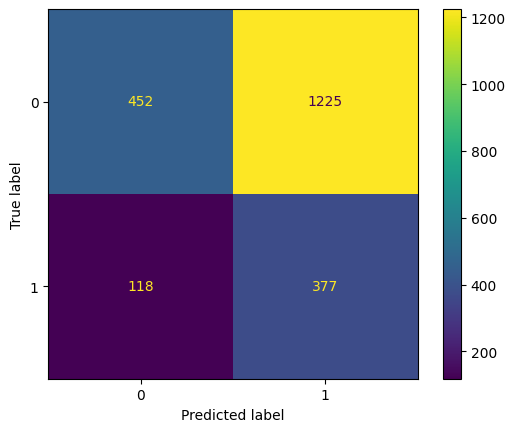

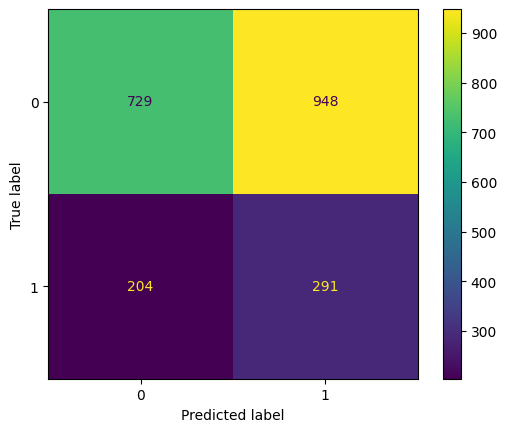

In [26]:
# Phase 3 – ML

import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

df = pd.read_parquet("data/processed/oscars_plus_bechdel_pol.parquet")

df["decade_num"] = (df["year_ceremony"] // 10) * 10
df["cat_group"] = df["Category"].str.extract(r'(Actor|Actress|Director|Picture)', expand=False).fillna("Other")
df["bechdel_pass"] = df["bechdel_pass"].fillna(False)
df["political_theme"] = df["political_theme"].fillna(False)
df["gender"] = df["gender"].fillna("Unknown")
df["Race"] = df["Race"].fillna("Unknown")

df["political_and_bechdel"] = (df["political_theme"].astype(int) * df["bechdel_pass"].astype(int))

X = df[["decade_num","political_theme","bechdel_pass", "gender","Race","cat_group","political_and_bechdel"]]
y = df["winner"].astype(int)

# Pre-processing
num_cols  = ["decade_num","political_and_bechdel"]
bool_cols = ["political_theme","bechdel_pass"]
cat_cols  = ["gender","Race","cat_group"]

pre = ColumnTransformer([("num", Pipeline([("sc", StandardScaler())]), num_cols), ("bool", "passthrough", bool_cols), ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)])

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=.2, random_state=0, stratify=y)

# Class weights
class_w = compute_class_weight("balanced", classes=np.array([0,1]), y=y_train)
rf_weights = {0: class_w[0], 1: class_w[1]}

# Logistic regression
pipe_lr = Pipeline([("pre", pre),("clf", LogisticRegression(max_iter=2000, solver="saga",class_weight="balanced",n_jobs=-1))])

pipe_lr.fit(X_train, y_train)
pred_lr = pipe_lr.predict(X_test)
proba_lr = pipe_lr.predict_proba(X_test)[:,1]

print("LogReg  accuracy:", accuracy_score(y_test, pred_lr))
print("LogReg  ROC AUC :", roc_auc_score(y_test, proba_lr))
ConfusionMatrixDisplay.from_predictions(y_test, pred_lr)

# Random forest
pipe_rf = Pipeline([("pre", pre), ("clf", RandomForestClassifier(n_estimators=300, max_depth=8, random_state=0, class_weight=rf_weights))])

pipe_rf.fit(X_train, y_train)
pred_rf  = pipe_rf.predict(X_test)
proba_rf = pipe_rf.predict_proba(X_test)[:,1]

print("RF accuracy:", accuracy_score(y_test, pred_rf))
print("RF ROC AUC :", roc_auc_score(y_test, proba_rf))
ConfusionMatrixDisplay.from_predictions(y_test, pred_rf)

“Balancing class weights improves recall from 0% to ≈60%, at the cost of overall accuracy. For awards prediction, recalling potential winners is more important than raw accuracy, so the balanced RF is chosen.”


In [40]:
%%bash
cd /content/DSA210-Term-Project
git add notebooks/ML.ipynb README.md
git commit -m "Phase-3 final metrics and explanation"
git push

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


fatal: pathspec 'notebooks/ML.ipynb' did not match any files
fatal: could not read Username for 'https://github.com': No such device or address


CalledProcessError: Command 'b'cd /content/DSA210-Term-Project\ngit add notebooks/ML.ipynb README.md\ngit commit -m "Phase-3 final metrics and explanation"\ngit push\n'' returned non-zero exit status 128.